In this notebook we train models to predict issue labels and test which models are effective. The basic flow of the notebook is such: one reads in the data, examines it and sets some parameters such as ignored labels, then trains both a SVM and fastText model as a binary classification task on each label. Negative samples are taken evenly throughout the other labels. Whichever labels' models perform better than some specified benchmark are then trained on the whole dataset and saved to Ceph. A text file is saved containing which labels' models are saved that a Flask app will then perform inference on.

#### First we import packages, set up our Ceph client, and read in the data.

In [1]:
import pandas as pd
import numpy as np
import itertools
import collections
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
import boto3
from dotenv import load_dotenv, find_dotenv
import sys
from joblib import dump
from model_classes import FtModel, SVM
from sklearn.feature_extraction.text import TfidfVectorizer

sys.path.append("../src/data")  # noqa
from preprocess import process  # noqa

[nltk_data] Downloading package stopwords to /opt/app-
[nltk_data]     root/src/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /opt/app-
[nltk_data]     root/src/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# load environment variables
load_dotenv(find_dotenv())

True

In [3]:
# whether to use ceph or store locally

use_ceph = bool(int(os.getenv('USE_CEPH')))

if use_ceph:
    s3_endpoint_url = os.environ["OBJECT_STORAGE_ENDPOINT_URL"]
    s3_access_key = os.environ["AWS_ACCESS_KEY_ID"]
    s3_secret_key = os.environ["AWS_SECRET_ACCESS_KEY"]
    s3_bucket = os.environ["OBJECT_STORAGE_BUCKET_NAME"]

    s3 = boto3.client(
        service_name="s3",
        aws_access_key_id=s3_access_key,
        aws_secret_access_key=s3_secret_key,
        endpoint_url=s3_endpoint_url,
    )

In [4]:
name = os.getenv("REPO_NAME")

if "/" in name:
    REPO = name
    USER = ""
else:
    USER = name
    REPO = ""

In [5]:
# repo data is saved as {org_name}-_-{repo_name}
# orginization data is saved as {org_name}

savename = USER if USER else REPO.replace("/", "-_-")
path = os.path.join("../data", savename + ".csv")
key = f"github-labeler/data/{savename}.csv"

if use_ceph:
    response = s3.get_object(Bucket=s3_bucket, Key=key)
    issues_df = pd.read_csv(response.get("Body")).drop_duplicates()
else:
    issues_df = pd.read_csv(path).drop_duplicates()

In [6]:
issues_df.sample(5)

,id,repo,title,body,created_at,created_by,num_labels,labels
5351,openshift/origin/13846,openshift/origin,flake Available origin-docker-excluder version...,```\r\nTASK [Get available excluder version] *...,2017-04-20 20:37:03,tbielawa,3,priority/P0\tarea/tests\tkind/test-flake
3545,openshift/origin/9168,openshift/origin,Containerized Node panic,We have nodes failing with a panic trace on At...,2016-06-03 20:50:34,gravis,3,priority/P2\tcomponent/diagnostics\tlifecycle/...
5696,openshift/origin/14551,openshift/origin,oc adm policy reconcile-cluster-roles --confir...,When user doesn't have permissions to update c...,2017-06-09 15:48:38,php-coder,3,component/cli\tpriority/P2\tlifecycle/rotten
962,openshift/origin/3180,openshift/origin,"Main content ""bounces"" when typing in filter c...",The nav bar is resized slightly larger and the...,2015-06-15 13:21:32,spadgett,3,kind/bug\tcomponent/web\tpriority/P3
2964,openshift/origin/7746,openshift/origin,503 service unavailable,I have successfully started the ha proxy route...,2016-03-03 01:00:04,deanpeterson,3,kind/question\tpriority/P3\tcomponent/routing


#### Here we examine the labels a bit. We can define any labels that are synonyms and define bots whose issues we don't want to include

In [7]:
# outputwith all labels more samples than "cutoff", in order.

cutoff = 0

label_lst = list(
    itertools.chain.from_iterable([ls.split("\t") for ls in issues_df.labels.dropna()])
)
counter = collections.Counter(label_lst)

for a, b in counter.most_common():
    if b > cutoff:
        print(f"{a} {b}")

priority/P2 3507
kind/bug 1868
lifecycle/rotten 1800
priority/P3 1387
priority/P1 1215
kind/test-flake 1085
component/cli 873
kind/question 748
area/usability 655
component/build 648
component/web 637
area/tests 599
component/apps 485
component/kubernetes 391
component/imageregistry 324
component/networking 323
lifecycle/stale 305
component/auth 298
sig/master 298
area/techdebt 294
component/routing 245
component/restapi 208
area/security 197
priority/P0 197
component/storage 187
component/internal-tools 173
component/install 169
lifecycle/frozen 163
sig/developer-experience 163
kind/post-rebase 153
component/composition 145
component/image 135
sig/security 125
sig/networking 118
area/documentation 114
area/performance 101
component/cluster-up 101
area/infrastructure 83
component/logging 75
sig/pod 69
help wanted 67
sig/storage 66
component/metrics 65
kind/feature 55
component/containers 52
area/reliability 50
area/examples 44
area/compatibility 41
component/templateservicebroker 41
si

In [8]:
# define synonyms, first in set will be used name

synsets = [
    ["kind/bug", "bug"],
]

In [9]:
# equate synonyms

for syn in synsets:

    def equate_syns(lbl):
        return syn[0] if lbl in syn[1:] else lbl

    def equate_list(lbllist):
        if type(lbllist) == str:
            return "\t".join(
                list(set([equate_syns(lbl) for lbl in lbllist.split("\t")]))
            )
        else:
            return lbllist

    issues_df.labels = issues_df.labels.apply(equate_list)

(0.0, 6.0)

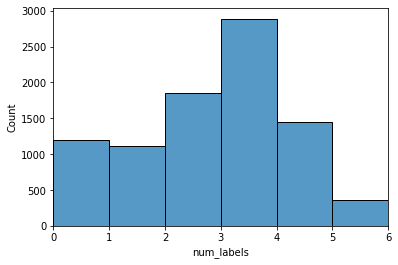

In [10]:
# output histogram of number of labels

ax = sns.histplot(issues_df.num_labels, bins=int(max(issues_df.num_labels)))
ax.set_xlim((0, 6))

In [11]:
# view most common issue creators

issues_df.created_by.value_counts(ascending=False).head(10)

smarterclayton    767
deads2k           374
kargakis          361
spadgett          349
bparees           297
liggitt           276
stevekuznetsov    273
mfojtik           256
soltysh           139
sosiouxme         108
Name: created_by, dtype: int64

In [12]:
# first find bots transparently tagged as such


def is_bot(name):
    return name[-5:] == "[bot]"


all_names = issues_df.created_by.unique()

bots = all_names[[is_bot(x) for x in all_names]]

print("bots found:")
for b in bots:
    print("\t", b)

bots found:


In [13]:
# choose any additional bot accounts whose issues to not count

additional_bots = ["sesheta"]

In [14]:
# filter out issues created by bots & their labels

bots = np.concatenate((bots, additional_bots))

issues_df = issues_df[issues_df.created_by.apply(lambda x: x not in bots)]

In [15]:
# most popular labels, nearly finalized

cutoff = 50
final_labels = []

label_lst = list(
    itertools.chain.from_iterable([ls.split("\t") for ls in issues_df.labels.dropna()])
)
counter = collections.Counter(label_lst)

for a, b in counter.most_common():
    if b > cutoff:
        print(f"{a} {b}")
        final_labels.append(a)

priority/P2 3507
kind/bug 1868
lifecycle/rotten 1800
priority/P3 1387
priority/P1 1215
kind/test-flake 1085
component/cli 873
kind/question 748
area/usability 655
component/build 648
component/web 637
area/tests 599
component/apps 485
component/kubernetes 391
component/imageregistry 324
component/networking 323
lifecycle/stale 305
component/auth 298
sig/master 298
area/techdebt 294
component/routing 245
component/restapi 208
area/security 197
priority/P0 197
component/storage 187
component/internal-tools 173
component/install 169
lifecycle/frozen 163
sig/developer-experience 163
kind/post-rebase 153
component/composition 145
component/image 135
sig/security 125
sig/networking 118
area/documentation 114
area/performance 101
component/cluster-up 101
area/infrastructure 83
component/logging 75
sig/pod 69
help wanted 67
sig/storage 66
component/metrics 65
kind/feature 55
component/containers 52


#### Here we can choose some labels that will discard an issue entirely from the dataset (e.g. 'bot' label), and we can choose some labels which we do not want to train a model to predict.

In [16]:
# choose labels whose issues you don't want to include in the dset (for either positive or negative sampling)

exclude = []

In [17]:
# remove those labels

for lbl in exclude:
    if lbl in final_labels:
        final_labels.remove(lbl)


def inclusion(lbl_list):
    if type(lbl_list) == str:
        return not any([lbl in lbl_list.split("\t") for lbl in exclude])
    else:
        return True


not_containing = issues_df.labels.apply(lambda x: inclusion(x))
issues_df = issues_df[not_containing]

In [18]:
# choose issues you do not wish to attempt to predict

dont_pred = [
    "priority/P2",
    "lifecycle/frozen",
    "lifecycle/stale",
    "priority/P3",
    "priority/P1",
    "lifecycle/rotten",
    "priority/P0",
    "lifecycle/rotten",
]

for dp in dont_pred:
    if dp in final_labels:
        final_labels.remove(dp)
    else:
        continue

(0.0, 6.0)

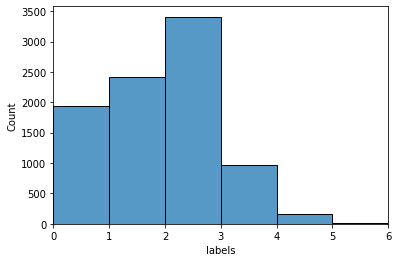

In [19]:
# output histogram of number of relevant labels, finalized

set_dp = set(dont_pred)

num_rel_issues = issues_df.labels.apply(
    lambda x: len(set(x.split("\t")).difference(set_dp)) if type(x) == str else 0
)

ax = sns.histplot(num_rel_issues, bins=int(max(num_rel_issues)))
ax.set_xlim((0, 6))

In [20]:
# preprocess text

issues_df["processed"] = issues_df.apply(
    lambda row: np.array(process(row["title"], row["body"])), axis=1
)

In [21]:
# hacky way to make tfidf work on also tokenized text


def dummy_fun(doc):
    return doc


tfidf = TfidfVectorizer(
    analyzer="word", tokenizer=dummy_fun, preprocessor=dummy_fun, token_pattern=None
)

tfidf.fit(issues_df.processed.values)

dump(tfidf, 'tfidf.joblib')

if use_ceph:
    s3.upload_file(
        Bucket=s3_bucket,
        Key=f"github-labeler/{savename}/tfidf.joblib",
        Filename="tfidf.joblib",
    )

In [22]:
def get_subdataset(label):
    """
    pass in a label name and get back a dataframe of positive & negative samples for the label
    we avoid taking unlabelled data as negative samples
    negative samples are distributed evenly amongst the other labels
    """
    labelled = issues_df[~issues_df.labels.isna()]
    final_labels_ = final_labels.copy()
    final_labels_.remove(label)
    pos_samples = labelled[labelled.labels.apply(lambda x: label in x.split("\t"))]
    n = len(pos_samples)
    remaining = labelled[labelled.id.apply(lambda x: label not in x.split("\t"))]
    n_neg = 0
    per_label = n // len(final_labels_)
    neg_ids = set()
    # evenly sample if we can
    # if not enough samples for a label, throw them all in and increase the remaining amount we need per label
    for i, lbl in enumerate(reversed(final_labels_)):
        neg_samples = remaining[remaining.labels.apply(lambda x: lbl in x.split("\t"))]
        if len(neg_samples) >= per_label:
            neg_samples = neg_samples.sample(per_label)
            n_neg += per_label
        else:
            n_neg += len(neg_samples)
            if i != len(final_labels_) - 1:
                per_label = (n - n_neg) // (len(final_labels_) - i - 1)
        remaining = remaining[
            remaining.labels.apply(lambda x: lbl not in x.split("\t"))
        ]
        neg_ids = neg_ids.union(set(neg_samples.id))
    # fill in potential gap with unlabelled issues, if needed
    if len(pos_samples) > len(neg_ids):
        unlabelled = issues_df.query("num_labels == 0")
        if len(unlabelled) > len(pos_samples) - len(neg_ids):
            neg_ids = neg_ids.union(
                set(unlabelled.sample(len(pos_samples) - len(neg_ids)).id)
            )
        else:
            neg_ids = neg_ids.union(set(unlabelled.id))
            pos_samples = pos_samples.sample(len(neg_ids))
    final_neg_samples = issues_df[issues_df.id.apply(lambda x: x in neg_ids)]
    x = pd.concat((final_neg_samples, pos_samples))
    y = np.concatenate((np.zeros(len(final_neg_samples)), np.ones(len(pos_samples))))
    return x, y.astype(int)

In [23]:
def predict_label(x_train, y_train, x_test, y_test, model_class=FtModel):
    """
    validates fastText model on the given label
    """
    model = model_class()
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    acc = np.mean(preds == y_test)
    precision_ = preds[preds == 1] == y_test[preds == 1]
    if len(precision_) != 0:
        prec = np.mean(precision_)
    else:
        prec = None
    recall_ = preds[y_test == 1] == y_test[y_test == 1]
    if len(recall_) != 0:
        rec = np.mean(recall_)
    else:
        rec = None
    return [acc, prec, rec]

Here we use something that is not necessarily k-fold cross validation. Our dataset is small, and randomized in the negative sampling process. What we do is run the trial multiple times and average the results. It is similar to k-fold cross validation but our dataset changes each time.

In [24]:
labels_dfs = []
for label in final_labels:
    data = []
    for i in range(5):
        x, y = get_subdataset(label)
        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)
        stats = predict_label(x_train, y_train, x_test, y_test, model_class=SVM)
        stats.append('svm')
        data.append(stats)
        stats = predict_label(x_train, y_train, x_test, y_test, model_class=FtModel)
        stats.append('ft')
        data.append(stats)
        n = len(x)
    stats_df = pd.DataFrame(data, columns = ['accuracy', 'precision', 'recall', 'model'])
    stats_df = stats_df.groupby('model').mean().reset_index()
    stats_df = stats_df.sort_values('accuracy', ascending = False).iloc[0]
    stats_df['n'] = n
    stats_df['label'] = label
    labels_dfs.append(stats_df)

In [25]:
# save and print the validation results

results_df = pd.DataFrame(labels_dfs).sort_values("n", ascending=False).reset_index(drop = True)

results_df

,model,accuracy,precision,recall,n,label
0,ft,0.622193,0.601722,0.761098,3736,kind/bug
1,svm,0.833641,0.800029,0.888497,2170,kind/test-flake
2,ft,0.718286,0.752696,0.646347,1746,component/cli
3,ft,0.702000,0.763575,0.593208,1496,kind/question
4,ft,0.710687,0.725599,0.649740,1310,area/usability
5,svm,0.800769,0.860276,0.733450,1296,component/build
6,svm,0.867451,0.910947,0.820620,1274,component/web
7,svm,0.760833,0.800040,0.712725,1198,area/tests
8,svm,0.819588,0.860887,0.749045,970,component/apps
9,svm,0.638217,0.627660,0.659721,782,component/kubernetes


In [26]:
# set conditions for saving the model of a potential label

min_accuracy = 0.75

min_precision = 0.75

min_recall = 0.0

# add in the labels you want to have a model for anyway

addins = ["kind/bug"]

condition1 = results_df.accuracy > min_accuracy
condition2 = results_df.precision > min_precision
cond = condition1 & condition2

to_save = results_df[cond | results_df.label.isin(addins)]

labels_to_save = to_save[["label", "model"]].values

to_save

,model,accuracy,precision,recall,n,label
0,ft,0.622193,0.601722,0.761098,3736,kind/bug
1,svm,0.833641,0.800029,0.888497,2170,kind/test-flake
5,svm,0.800769,0.860276,0.733450,1296,component/build
6,svm,0.867451,0.910947,0.820620,1274,component/web
7,svm,0.760833,0.800040,0.712725,1198,area/tests
8,svm,0.819588,0.860887,0.749045,970,component/apps
14,svm,0.818644,0.781162,0.871778,588,area/techdebt
22,svm,0.774194,0.833404,0.738610,306,kind/post-rebase
27,svm,0.821739,0.847409,0.789917,228,area/documentation
28,svm,0.809756,0.818056,0.766739,202,component/cluster-up


In [27]:
labels_to_save

array([['kind/bug', 'ft'],
       ['kind/test-flake', 'svm'],
       ['component/build', 'svm'],
       ['component/web', 'svm'],
       ['area/tests', 'svm'],
       ['component/apps', 'svm'],
       ['area/techdebt', 'svm'],
       ['kind/post-rebase', 'svm'],
       ['area/documentation', 'svm'],
       ['component/cluster-up', 'svm'],
       ['area/infrastructure', 'svm'],
       ['component/logging', 'svm'],
       ['sig/pod', 'svm'],
       ['sig/storage', 'svm'],
       ['component/metrics', 'svm']], dtype=object)

In [28]:
if not os.path.exists("./saved_models"):
    os.mkdir("./saved_models")

if not os.path.exists(f"./saved_models/{savename}"):
    os.mkdir(f"./saved_models/{savename}")

model_dic = {"svm": SVM, "ft": FtModel}

if use_ceph:
    for label, mod in labels_to_save:
        X, y = get_subdataset(label)
        model = model_dic[mod]()
        model.fit(X, y)
        lbl_path = os.path.join("saved_models", label.replace("/", "_"))
        lbl_path += ".bin" if mod == "ft" else ".joblib"
        model.save(lbl_path)
        key = f"github-labeler/{savename}/{lbl_path}"
        s3.upload_file(Bucket=s3_bucket, Key=key, Filename=lbl_path)
        os.remove(lbl_path)
else:
    for label in labels_to_save:
        X, y = get_subdataset(label)
        model = model_dic[model]()
        model.fit(X, y)
        lbl_path = os.path.join("saved_models", label.replace("/", "_"))
        lbl_path += ".bin" if model == "ft" else ".joblib"
        model.save(lbl_path)

In [29]:
# save information of who to ignore (so the app knows not to tag these issues)

with open("botlist.txt", "w") as f:
    for b in bots:
        f.write(b)
        f.write("\n")

# save label names

with open("labellist.txt", "w") as f:
    for label, model in labels_to_save:
        f.write(label + "\t" + model)
        f.write("\n")

if use_ceph:
    s3.upload_file(
        Bucket=s3_bucket,
        Key=f"github-labeler/{savename}/botlist.txt",
        Filename="botlist.txt",
    )
    s3.upload_file(
        Bucket=s3_bucket,
        Key=f"github-labeler/{savename}/labellist.txt",
        Filename="labellist.txt",
    )